## XGBOOST

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.dates as mdates
import pickle
from datetime import timedelta
import os

##### Read data

In [2]:
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (15539, 38)


,Posted Time,Width,Length,Floors,Rooms,Toilets,Price per m2,1 Part Residential,All Residential,Back Expansion,...,House Direction_SOUTHWEST,House Direction_WEST,Furnishing Sell_BASIC_FINISHING,Furnishing Sell_FULLY_FURNISHED,Furnishing Sell_HIGH_END_FURNITURE,Furnishing Sell_RAW_HANDOVER,Land Type_AGRICULTURAL_LAND,Land Type_INDUSTRIAL_LAND,Land Type_PROJECT_LAND,Land Type_RESIDENTIAL_LAND
0,2025-01-31,2.236068,4.472136,0.0,0.0,0.0,1.252763,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2025-02-01,2.236068,4.472136,0.0,0.0,0.0,1.252763,0,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2025-01-13,2.236068,3.872983,0.0,0.0,0.0,1.554630,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2025-02-07,2.236068,5.477226,0.0,0.0,0.0,1.311683,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2025-02-02,2.236068,4.472136,0.0,0.0,0.0,1.791759,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Create time feature

In [3]:
df['year']      = df['Posted Time'].dt.year
df['month']     = df['Posted Time'].dt.month
df['day']       = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter']   = df['Posted Time'].dt.quarter
# Mùa xuân (tháng 1-3), Mùa hè (tháng 4-6), Mùa thu (tháng 7-9), Mùa đông (tháng 10-12)
# season_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}
# df['season'] = df['month'].map(season_dict)
# cyclical features
df['month_sin']     = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos']     = np.cos(2 * np.pi * df['month'] / 12)
df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df.drop(columns=['Posted Time'], inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15539 entries, 0 to 15538
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Width                               15539 non-null  float64
 1   Length                              15539 non-null  float64
 2   Floors                              15539 non-null  float64
 3   Rooms                               15539 non-null  float64
 4   Toilets                             15539 non-null  float64
 5   Price per m2                        15539 non-null  float64
 6   1 Part Residential                  15539 non-null  int64  
 7   All Residential                     15539 non-null  int64  
 8   Back Expansion                      15539 non-null  int64  
 9   Car Alley                           15539 non-null  int64  
 10  Frontage                            15539 non-null  int64  
 11  No Residential                      15539

#### EDA: Correlation matrix

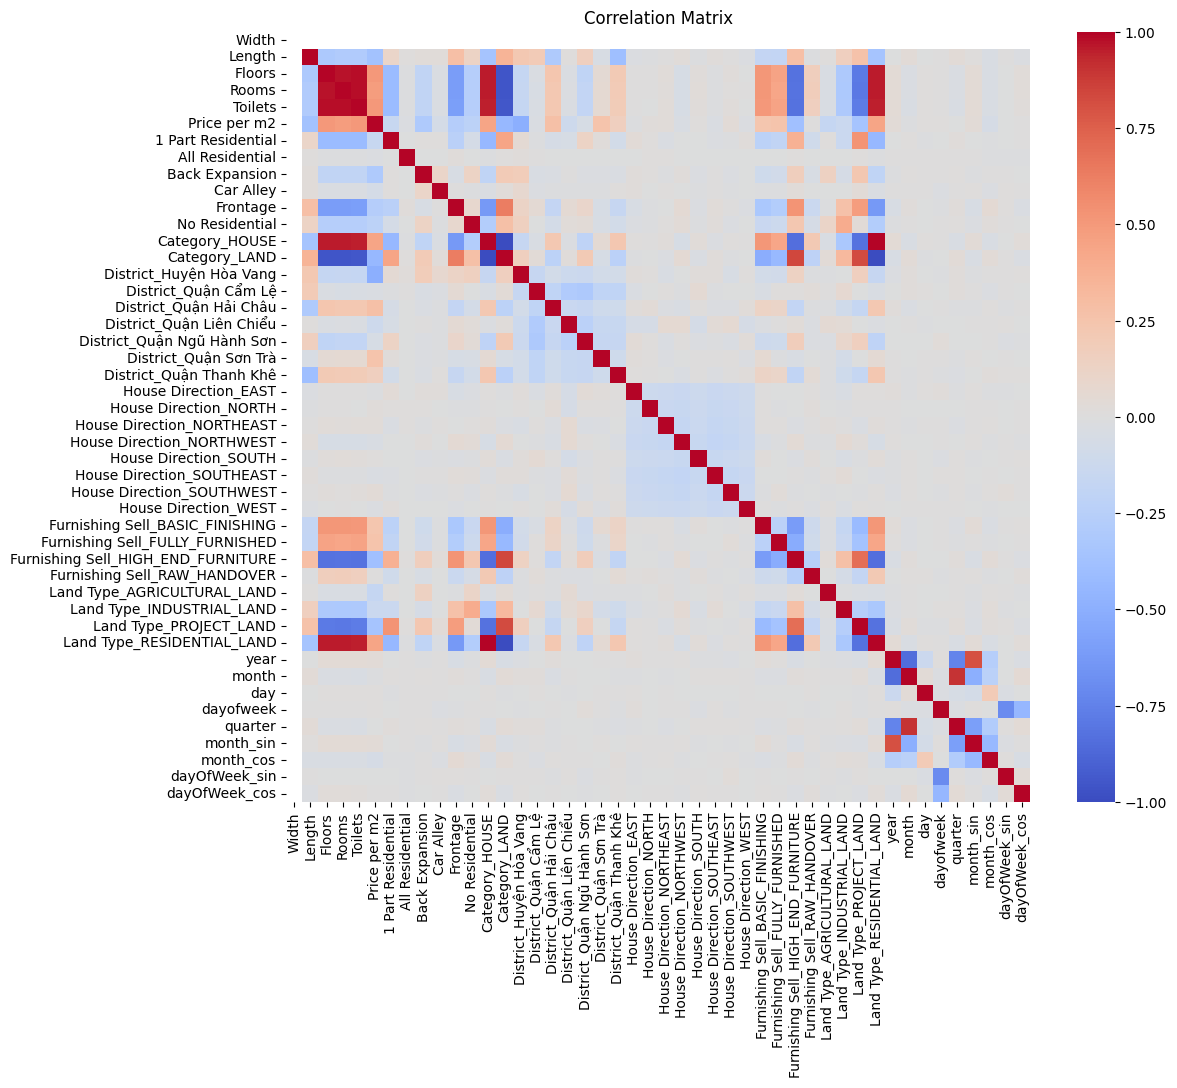

Top 10 features correlated with Price per m2:
 District_Huyện Hòa Vang               0.503962
Floors                                0.501110
Toilets                               0.501034
Rooms                                 0.476686
Category_HOUSE                        0.438287
Land Type_RESIDENTIAL_LAND            0.438287
Category_LAND                         0.438287
Furnishing Sell_HIGH_END_FURNITURE    0.389374
Length                                0.371995
Land Type_PROJECT_LAND                0.352896
Name: Price per m2, dtype: float64


In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()

corr_with_price = df.corr()['Price per m2'].abs().sort_values(ascending=False).drop('Price per m2')
print("Top 10 features correlated with Price per m2:\n", corr_with_price.head(10))

#### Split data

In [5]:
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=26
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (12431, 45), X_test: (3108, 45)


### Train model

In [6]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=26
)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

#### Evaluate

In [7]:
# Evaluate on Training Set
y_train_pred = xgb_reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = xgb_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== XGBoost Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.4f}")

=== XGBoost Evaluation ===
Training MSE: 0.08430, RMSE: 0.29034, MAE: 0.21486, R2: 0.7081
Test MSE: 0.09317, RMSE: 0.30524, MAE: 0.22333, R2: 0.6714


#### Scatter actual vs predicted

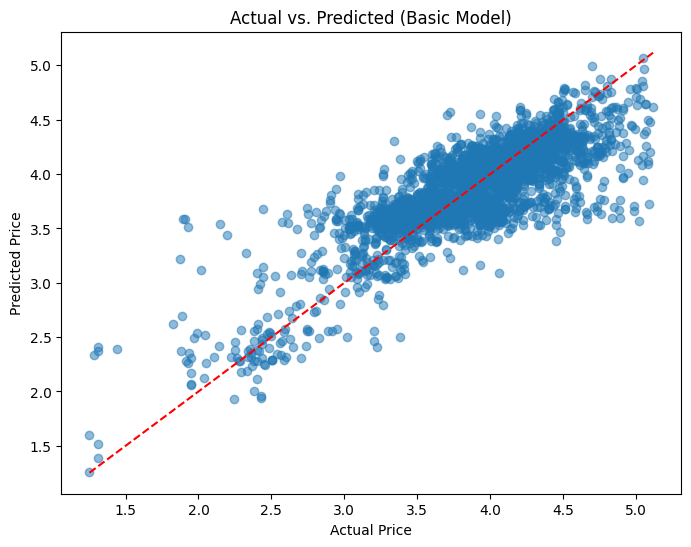

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted (Basic Model)")
plt.show()

#### Feature importance

<Figure size 800x600 with 0 Axes>

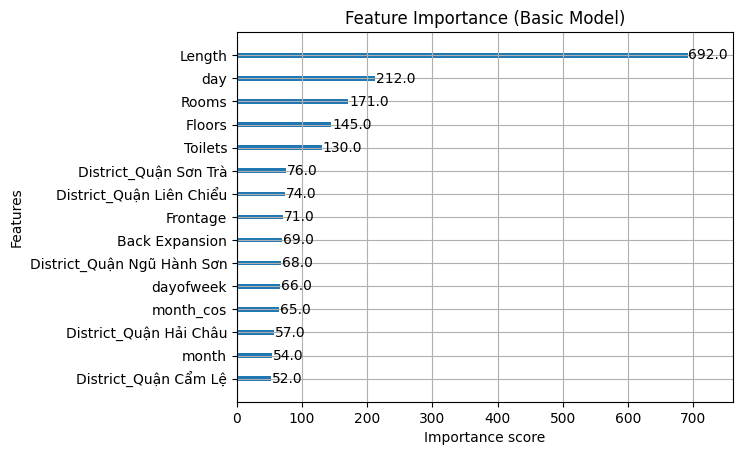

In [9]:
plt.figure(figsize=(8,6))
xgb.plot_importance(xgb_reg, max_num_features=15)
plt.title("Feature Importance (Basic Model)")
plt.show()

#### Hyperparameter tuning

In [10]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7, 9],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 1, 5],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2],
# }
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=26)

grid = GridSearchCV(
    model, param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_score = -grid.best_score_
best_params = grid.best_params_

print("\n=== Best Configuration for random_state=26 ===")
print(f"Lowest MSE: {best_score:.4f}")
print("Best Params:", best_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

=== Best Configuration for random_state=26 ===
Lowest MSE: 0.0943
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


#### Evaluate optimized model

=== Optimized XGBoost Evaluation ===
Training MSE: 0.05655, RMSE: 0.23780, MAE: 0.17212, R2: 0.80421
Test MSE: 0.08993, RMSE: 0.29988, MAE: 0.21646, R2: 0.68285


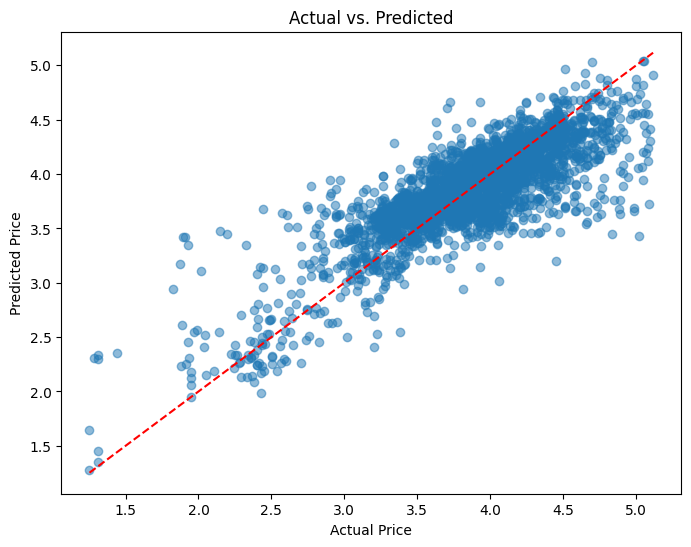

In [11]:
best_model = grid.best_estimator_

y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Optimized XGBoost Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")

# Scatter optimal
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.show()

#### Error distribution

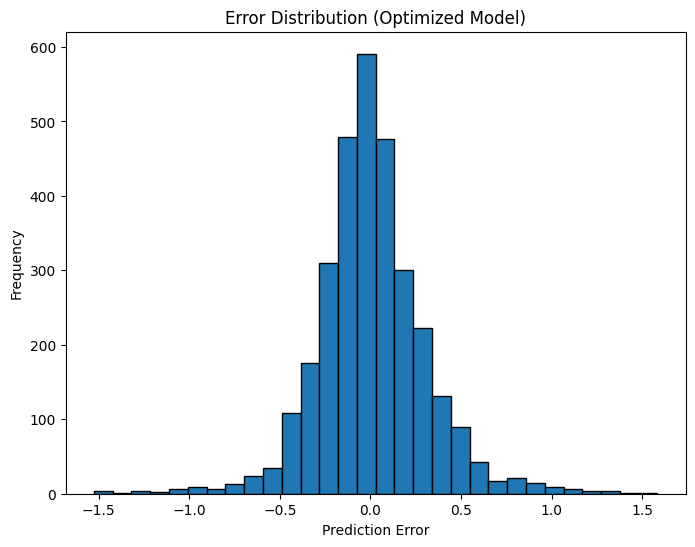


Cross-val MSE mean: 0.09430, std: 0.00284


In [12]:
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (Optimized Model)")
plt.show()

# 11. Cross-validation trên train
cv_scores = cross_val_score(best_model, X_train, y_train,
                            cv=5, scoring='neg_mean_squared_error')
print("\nCross-val MSE mean: {:.5f}, std: {:.5f}".format(-cv_scores.mean(), cv_scores.std()))


#### Fit final model on full dataset

In [13]:
final_model = xgb.XGBRegressor(**grid.best_params_,
                               objective='reg:squarederror',
                               random_state=26)
final_model.fit(X, y)
print("Training on full dataset complete.")

Training on full dataset complete.


#### Export model

In [14]:
with open('xgboost_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)
with open(output_dir + 'xgboost_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
    
print("Saved final model to xgboost_final_model.pkl")

Saved final model to xgboost_final_model.pkl


### Test model

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# season_dict phải khớp với lúc bạn tạo season
# season_dict = {1: 0, 2: 0, 3: 0,
#                4: 1, 5: 1, 6: 1,
#                7: 2, 8: 2, 9: 2,
#                10: 3,11: 3,12: 3}

# Giả sử:
#   - X là DataFrame chứa đầy đủ các feature (đã drop 'Posted Time')
#   - final_model là XGBRegressor đã train trên X, y
# Lấy mẫu baseline (ở đây dùng dòng cuối của X)
base = X.iloc[-1].copy()

# Ngày bắt đầu forecast: hôm nay (chỉ lấy phần date)
start_date = pd.Timestamp.now().normalize()

results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Cập nhật các feature thời gian
    f['year']      = date.year
    f['month']     = date.month
    f['day']       = date.day
    f['dayofweek'] = date.weekday()
    f['quarter']   = date.quarter
    # f['season']    = season_dict[date.month]
    
    # cyclical features
    f['month_sin']     = np.sin(2 * np.pi * date.month / 12)
    f['month_cos']     = np.cos(2 * np.pi * date.month / 12)
    f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
    f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)
    
    # Dự đoán
    X_pred = f.values.reshape(1, -1)
    pred_price = final_model.predict(X_pred)[0]
    
    results.append({
        'Date': date,
        'Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

print(forecast_df.head())
print(forecast_df.tail())


        Date  Predicted_Price_per_m2
0 2025-05-08                4.672650
1 2025-05-09                4.668571
2 2025-05-10                4.735096
3 2025-05-11                4.829276
4 2025-05-12                4.677662
         Date  Predicted_Price_per_m2
85 2025-08-01                4.528155
86 2025-08-02                4.559576
87 2025-08-03                4.551938
88 2025-08-04                4.592378
89 2025-08-05                4.593317


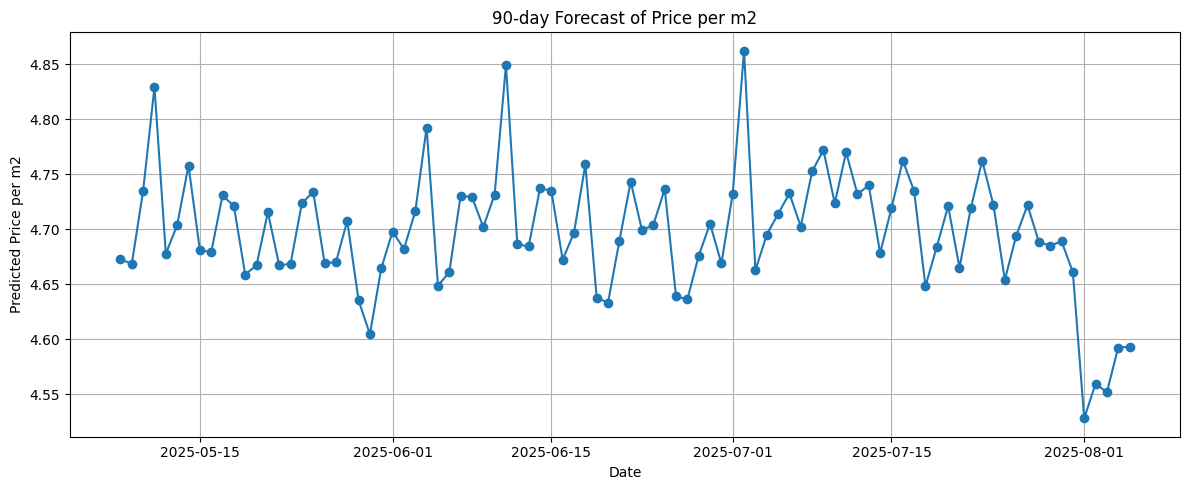

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], marker='o')
plt.title('90-day Forecast of Price per m2')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()
